In [1]:
import numpy as np
import time
import torch
import torchvision
from torch import nn,optim
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def get_data_ch7():
    data=np.genfromtxt(r'F:\study\ml\DataSet\airfoil_self_noise\airfoil_self_noise.dat',
                      delimiter='\t')
    data=(data-data.mean(axis=0)) / data.std(axis=0)
    features=torch.tensor(data[:1500,:-1],dtype=torch.float32)
    labels=torch.tensor(data[:1500,-1],dtype=torch.float32)
    return features,labels

In [9]:
features,labels=get_data_ch7()
features.shape

torch.Size([1500, 5])

In [73]:
def linreg(x,w,b):
    return torch.mm(x,w)+b

def squared_loss(y_hat,y):
    return (y_hat-y.view(y_hat.size()))**2 /2

def sgd_momentum(params,states,hyperparams):
    for p,v in zip(params,states):
        v.data=hyperparams['momentum']*v.data +hyperparams['lr']*p.grad.data
        p.data -=v.data

def init_momentum_states():
    v_w=torch.zeros((features.size()[1],1),dtype=torch.float32)
    b_w=torch.zeros((1),dtype=torch.float32)
    return (v_w,b_w)

In [74]:
init_momentum_states()

(tensor([[0.],
         [0.],
         [0.],
         [0.],
         [0.]]), tensor([0.]))

In [2]:
def train_ch7(optimizer_fn,
             states,
             hyperparams,
             features=features,
             labels=labels,
             batch_size=10,
             num_epochs=2):
    net,loss=linreg,squared_loss
    
    w=torch.nn.Parameter(
        torch.tensor(np.random.normal(0,0.01,size=(features.size()[1],1)),
                    dtype=torch.float32,requires_grad=True))
    b=torch.nn.Parameter(
        torch.tensor(np.zeros(1),
                    dtype=torch.float32,requires_grad=True))
    
    data_iter=torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features,labels),batch_size=batch_size,
    shuffle=True)
    
    def eval_loss():
        return (loss(net(features,w,b),labels)).mean() /2
        
    
    ls=[eval_loss()]
    for _ in range(num_epochs):
        start=time.time()
        for batch_i,(X,y) in enumerate(data_iter):
            l=(loss(net(X,w,b),y)).mean()
#             ls.append(l)
#             print('loss :',l)
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            optimizer_fn([w,b],states,hyperparams)
            if (batch_i+1)*batch_size % 100 ==0:
                ls.append(eval_loss())
#             print(batch_i)
#     print('ls len :',len(ls))
    print('loss %f, %f sec per epoch' % (ls[-1],time.time()-start))
    plt.plot(np.linspace(0,num_epochs,len(ls)),ls,'-')
    plt.xlabel('epochs')
    plt.ylabel('loss')

NameError: name 'features' is not defined

loss 0.243581, 0.052003 sec per epoch


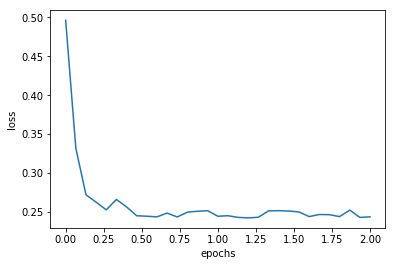

In [133]:
train_ch7(sgd_momentum, init_momentum_states(), {
    'lr': 0.02,
    'momentum': 0.5
}, features, labels)

loss 0.290616, 0.054003 sec per epoch


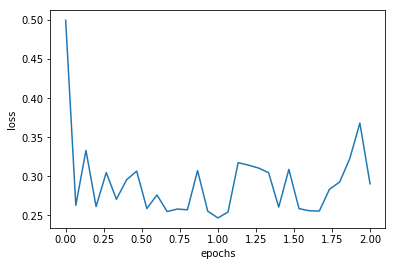

In [115]:
train_ch7(sgd_momentum, init_momentum_states(), {
    'lr': 0.02,
    'momentum': 0.9
}, features, labels)

In [119]:
# train_ch7(sgd_momentum, init_momentum_states(), {
#     'lr': 0.004,
#     'momentum': 0.9
# }, features, labels)

In [138]:
def train_pytorch_ch7(optimizer_fn,optimizer_hyperparams,features,labels,batch_size=10,
                     num_epochs=2):
    net=nn.Sequential(nn.Linear(features.shape[-1],1))
    loss=nn.MSELoss()
    optimizer=optimizer_fn(net.parameters(),**optimizer_hyperparams)
    
    data_iter=torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(features,labels),
    batch_size=batch_size,shuffle=True)
    
    def eval_loss():
        return loss(net(features).view(-1),labels).item() /2
    ls=[eval_loss()]
    for _ in range(num_epochs):
        start=time.time()
        for batch_i,(X,y) in enumerate(data_iter):
            l=loss(net(X).view(-1),y)/2
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (batch_i+1) * batch_size % 100 ==0:
#                 print(eval_loss())
                ls.append(eval_loss())
    print('loss: %f, %f sec per epoch' % (ls[-1],time.time()-start))
    plt.plot(np.linspace(0,num_epochs,len(ls)),ls,'-')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    

loss: 0.244092, 0.047003 sec per epoch


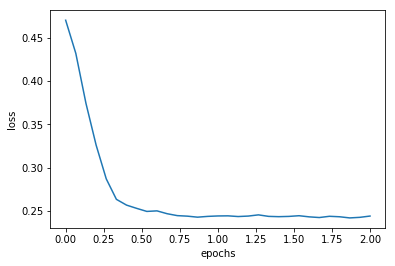

In [273]:
train_pytorch_ch7(torch.optim.SGD, {
    'lr': 0.004,
    'momentum': 0.9
}, features, labels)